## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
train.shape

(42000, 785)

In [4]:
test.shape

(28000, 784)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

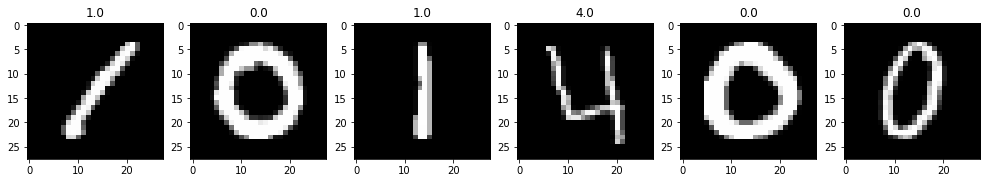

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [8]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_label, train_img, test_size=0.1, random_state=42)

## Аугментация тренировочной выборки

In [9]:
def img_variate(img):
    img=img.reshape((28,28))
    kernel = np.ones((2,2), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    img_dilation = cv2.dilate(img, kernel, iterations=1)
    img_dilation2 = cv2.dilate(img, kernel, iterations=2)
    return [img,img_erosion,img_dilation,img_dilation2]

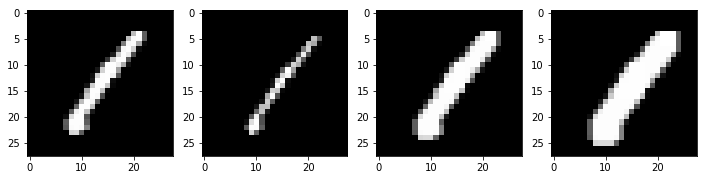

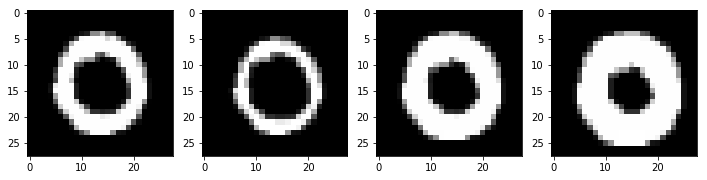

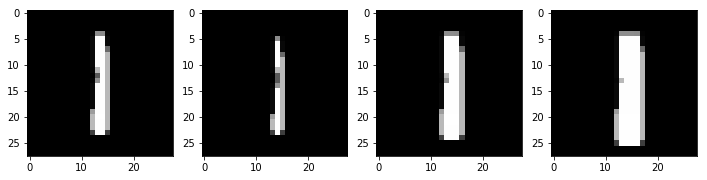

In [10]:
for img in train_img[0:3]:
    variants=img_variate( img.reshape((28,28)) )
    fig=plt.figure(figsize=(12,6))
    for i,sample in enumerate(variants):
       fig.add_subplot(1,len(variants),i+1) 
       plt.imshow(sample, cmap='gray')
    

In [11]:
%%time
import tqdm
tmpx=x_train
tmpy=y_train
x_train=[]
y_train=[]
for i,img in enumerate(tqdm.tqdm(tmpx)):
    imgs=img_variate(img)
    lbls=[tmpy[i]]*len(imgs)
    x_train+=imgs
    y_train+=lbls
x_train=[x.flatten() for x in x_train]
y_train=[np.int(y) for y in y_train]
x_val=[x.flatten() for x in x_val]
y_val=[np.int(y) for y in y_val]

100%|██████████| 37800/37800 [00:00<00:00, 37842.22it/s]


CPU times: user 1.1 s, sys: 392 ms, total: 1.49 s
Wall time: 1.38 s


In [12]:
print(len(x_train),len(x_val))

151200 4200


## Постройка модели PCA+KNN

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
model=Pipeline([('feature_sel', PCA(n_components=32)), 
                ('cl', KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree',n_jobs=4))])

In [14]:
%%time
model.fit(x_train[:],y_train[:])

CPU times: user 15.9 s, sys: 5.36 s, total: 21.3 s
Wall time: 7.06 s


Pipeline(steps=[('feature_sel', PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('cl', KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=3, p=2,
           weights='uniform'))])

## Визуализация фичей PCA


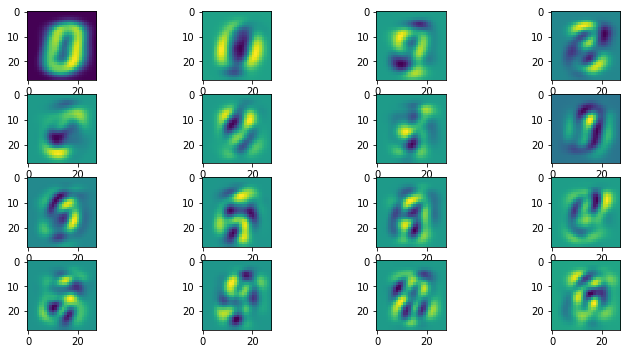

In [15]:
pca=model.named_steps['feature_sel']
fig=plt.figure(figsize=(12,12))
for i,c in enumerate(pca.components_[:16]):
    fig.add_subplot(len(pca.components_)//4,4,i+1)
    plt.imshow(np.reshape(c,(28,28)))

## Оцениваем качество решения на валидационной выборке

In [16]:
%%time
import tqdm
g=100
y_val_predict=[]
x_val=[x.flatten() for x in x_val]
for i in tqdm.tqdm(range(len(x_val)//g)):
    x_cur=x_val[i*g:i*g+g]
    y_cur=list(model.predict(x_cur))
    y_val_predict+=y_cur

100%|██████████| 42/42 [00:18<00:00,  2.41it/s]

CPU times: user 48.1 s, sys: 6.09 s, total: 54.2 s
Wall time: 18.2 s


In [17]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.975476190476


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_val_predict,y_val))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       409
          1       0.99      0.97      0.98       480
          2       0.99      0.96      0.97       432
          3       0.96      0.98      0.97       494
          4       0.97      0.98      0.98       391
          5       0.98      0.96      0.97       346
          6       0.99      0.98      0.99       404
          7       0.97      0.97      0.97       435
          8       0.96      0.99      0.97       392
          9       0.96      0.96      0.96       417

avg / total       0.98      0.98      0.98      4200



In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_val_predict))

[[404   0   2   0   0   0   1   0   0   1]
 [  0 468   1   0   0   0   1   1   0   0]
 [  1   2 415   0   1   0   0   1   0   0]
 [  0   3   5 486   0   6   0   1   4   1]
 [  0   0   0   0 385   0   2   1   0   9]
 [  1   1   0   1   0 332   2   0   0   2]
 [  2   0   0   0   0   2 397   0   1   0]
 [  0   6   4   0   1   0   0 424   0   3]
 [  1   0   3   2   1   5   1   1 387   2]
 [  0   0   2   5   3   1   0   6   0 399]]


## Предсказания на тестовых данных

In [20]:
%%time
pred_test = model.predict(test_img.reshape(test_img.shape[0],-1))

CPU times: user 5min 7s, sys: 348 ms, total: 5min 8s
Wall time: 1min 24s


## Визуализируем предсказания

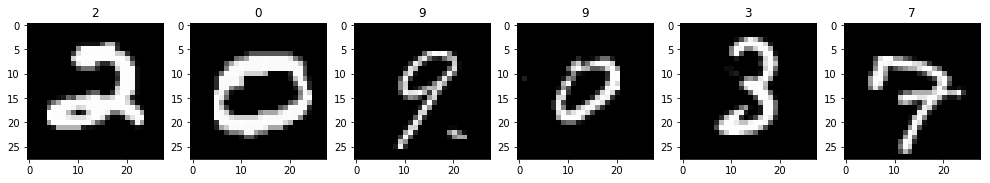

In [21]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [22]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%d,%d\n' % (i, p))

In [23]:
# Your submission scored 0.97528